# Assignment 1 - Image Fundamentals

Class: COMP 5970 - Computer Vision

Author: Chris Hinkson

Email: cmh0201@auburn.edu

*Personal Contribution Statement: This was an individual project and I did everything in it.*

## Task 1 Report: Photometric Decoder

The goal of Task 1 is to build a Photometric Decoder that reveals a hidden phrase or message in a provided photograph. For full details, see [Assignment1.pdf](../Assignment1.pdf).

### Approach Strategy

My approach strategy for Task 1 was to first build a set of tools that would allow me to easily modify values. I could then use these tools to complete photometric operations to find the optimal configuration for revealing the code. 

I started off by just adjusting each setting on its own (brightness, contrast, gamma, greyscale) to see if there were any obvious limits; from this, I found that each setting for brightness, contrast, and gamma would need a lot of balance. By setting a modifier to a high value (for brightness, > 1, for contrast, > 5, for gamma, > 3), the image would quickly not even be recognizable as having any content. I tested combinations of each, slowly adjusting it to be slightly more revealing and then moving on to the next photometric modifier.

I eventually found that brightness values close to 0.5, contrast values around 2-3, and gamma values < 1 performed the best. I continued to make smaller and smaller adjustments until I found the optimal configuration, described in the Results section of this report.

### Implementation

The first step of my implementation was to create all of the tools necessary for modifying the image. I initially made an ImageModifier class that handles the brightness, contrast, gamma, and greyscale modifications to an image, all of which are based on Dr. Aakur's examples from class. I then created an ImageDisplay class to easily display and save images using matplotlib. 

To easily test different image configurations, I used ipywidgets, which are designed for Jupyter notebooks. These allow for things like sliders (which I used for changing brightness, contrast, gamma, and greyscale setting) and buttons (which I used to save configurations found in the interactive display). 

Overall, the implementation shown here is relatively simple: create classes to handle image modifications and displays -> use ipywidgets to interactively control these modifications -> identify the best results.

### Dependencies and Runtime Instructions

For Task 1, there are several dependencies required for the program:
1) Python's [Enums](https://docs.python.org/3/library/enum.html) and [Warnings](https://docs.python.org/3/library/warnings.html) for system support
2) [Numpy](https://numpy.org/) for storing images
3) [CV2](https://opencv.org/) for loading and saving images
4) [IPython Display Module](https://ipython.readthedocs.io/en/9.0.0/api/generated/IPython.display.html), [ipywidget](https://ipywidgets.readthedocs.io/en/stable/), and [matplotlib](https://matplotlib.org/) for interactive output

Before running the program, ensure that an `images` directory is located at the same file level as this program (in Colab, just place the directory at the top-level of the file browser). Inside the images directory, place the `photometric_hidden_image.png`.

To run the program, you simply need to run the below three cells. The first cell will create all of the needed classes, and the second will initialize some instances of them and provide an interactive image output with sliders for controlling the image modification parameters and saving any modified images. Note that the save button will save images to the [images](images/) directory. The third and final cell for Task 1 recreates the image configuration that I found best-reveals the secret phrase.

### Task 1 Results

With the interactive image output provided in the second code cell below, I was able to adjust values and find a configuration that best reveals the secret code phrase "CV is cool" (and spongebob). I created the third code cell to always display this configuration.

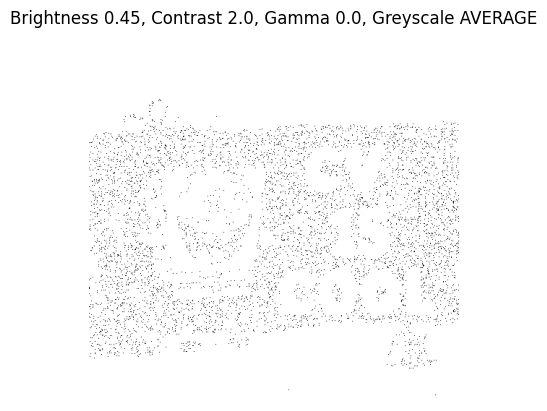

While other values for the brightness, contrast, gamma, and greyscale setting can also somewhat reveal the phrase, these settings provided the clearest identification of the phrase possible.


In [92]:
'''
MODULE IMPORTS
'''

# System
from enum import Enum
from warnings import warn

# Data
import numpy as np

# Image Processing
import cv2

# Display
from IPython.display import display, clear_output
from ipywidgets import interact, FloatSlider, SelectionSlider, Button
import matplotlib.pyplot as plt

'''
ENUM CREATION

Enums are used to help with code readability and usability:
- GreyscaleType: Enum for the different types of grayscale conversions
'''
class GreyscaleType(Enum):
	COLOR = 0
	AVERAGE = 1
	WEIGHTED = 2

'''
IMAGE DISPLAY CLASS

The first class contains methods for displaying images in the Jupyter environment
via IPython display. It also allows for a title to be displayed above the image.
'''
class ImageDisplay:

	# Class Constructor
	def __init__(self):

		# Initialize instance variables
		self.image = None
		self.title = "Image"
		self.im = None

		# Setup matplotlib
		self.fig, self.ax = plt.subplots()
		plt.close(self.fig)

	# Show Image
	def showImage(self, image, title: str="Image", doGreyMap: bool=False):

		# Save image
		self.image = image
		self.title = title

		# Display the image, mapped in greyscale if specified
		if self.im is None:
			self.ax.axis("off")
			self.im = self.ax.imshow(image, cmap=("gray" if doGreyMap else None))
		else:
			self.im.set_data(image)
			self.im.set_cmap(cmap=("gray" if doGreyMap else None))

		# Set title
		self.ax.set_title(title)

		# Draw new image then clear and display output
		self.fig.canvas.draw_idle()
		clear_output(wait=True)
		display(self.fig)

	# Save Image
	def saveImage(self, filename: str=None):

		# Ensure an image has been displayed
		if self.image is None:
			raise ValueError("No image has been displayed yet!")
		
		# If no filename provided, use title
		if filename is None or filename == "":
			filename = f"images/{self.title.replace(' ', '_')}.png"

		# Save the image to a file
		self.fig.savefig(filename)

'''
IMAGE MODIFICATION CLASS

This class will provide methods for modifying images inline with the assignment
description. Note that this uses cv2's MatLike type for images, since cv2 will be
used for image loading and saving.
'''
class ImageModifier:

	# Class Constructor
	def __init__(self, image: cv2.typing.MatLike):

		# Initialize instance variables
		self.image = image

	# Get Image Method
	def getImage(self, greyscaleType: GreyscaleType=GreyscaleType.COLOR) -> cv2.typing.MatLike:
		# Ensure image has been set
		if self.image is None:
			raise ValueError("No image has been loaded yet!")

		# Return the image in the specified greyscale type
		if greyscaleType == GreyscaleType.AVERAGE:
			return self.changeImageGreyscale(self.image, GreyscaleType.AVERAGE)
		elif greyscaleType == GreyscaleType.WEIGHTED:
			return self.changeImageGreyscale(self.image, GreyscaleType.WEIGHTED)
		else:
			return self.image

	# Change Image Brightness (Inspired by Dr. Aaukur's class example)
	def changeImageBrightness(self, image: cv2.typing.MatLike=None, brightnessModifier: int=0, returnGreyscaleType: GreyscaleType=GreyscaleType.COLOR) -> cv2.typing.MatLike:

		# Ensure image has been set, and if not, use the instance image
		if image is None:
			image = self.image

		# Adjust brightness for all pixels in img
		image = (image.astype(np.float32)/255.) + brightnessModifier

		# Perform intensity clipping for [0,1]
		image = np.where(image > 1, 1, image)
		image = np.where(image < 0, 0, image)

		# Set the image back to [0,255]
		image = (image * 255).astype(np.uint8)

		# Return the modified image, in the specified greyscale type
		if returnGreyscaleType == GreyscaleType.AVERAGE:
			return self.changeImageGreyscale(image, GreyscaleType.AVERAGE)
		elif returnGreyscaleType == GreyscaleType.WEIGHTED:
			return self.changeImageGreyscale(image, GreyscaleType.WEIGHTED)
		else:
			return image

	# Make Image Greyscale (Inspired by Dr. Aaukur's class example)
	def changeImageGreyscale(self, image: cv2.typing.MatLike=None, greyscaleType: GreyscaleType=GreyscaleType.WEIGHTED) -> cv2.typing.MatLike:

		# Ensure image has been set, and if not, use the instance image
		if image is None:
			image = self.image

		# Build average-greyscale image
		if greyscaleType == GreyscaleType.AVERAGE:
			greyscaleImage = (image[:,:,0].astype(float) + image[:,:,1].astype(float) + image[:,:,2].astype(float))/3
			greyscaleImage = greyscaleImage.astype (np.uint8)
			return greyscaleImage

		# Build weighted-greyscale image
		elif greyscaleType == GreyscaleType.WEIGHTED:
			greyscaleImage = (0.2125 * image[:,:,0].astype(float) + 0.7154 * image[:,:,1].astype(float) + 0.721 * image[:,:,2].astype(float))/3
			greyscaleImage = greyscaleImage.astype (np.uint8)
			return greyscaleImage
		
		# If color, return original image
		else:
			return image

	# Change Image Contrast (Inspired by Dr. Aaukur's class example)
	def changeImageContrast(self, image: cv2.typing.MatLike=None, contrastModifier: float=1.0, returnGreyscaleType: GreyscaleType=GreyscaleType.COLOR) -> cv2.typing.MatLike:

		# Ensure image has been set, and if not, use the instance image
		if image is None:
			image = self.image

		# Adjust contrast for all pixels in image (can either be single modifier for all or a matrix)
		image = image.astype(np.float32)/255.
		image = contrastModifier * image

		# Perform intensity clipping for [0,1]
		image = np.where(image > 1, 1, image)
		image = np.where(image < 0, 0, image)

		# Set the image back to [0,255]
		image = (image * 255).astype(np.uint8)

		# Return the modified image, in the specified greyscale type
		if returnGreyscaleType == GreyscaleType.AVERAGE:
			return self.changeImageGreyscale(image, GreyscaleType.AVERAGE)
		elif returnGreyscaleType == GreyscaleType.WEIGHTED:
			return self.changeImageGreyscale(image, GreyscaleType.WEIGHTED)
		else:
			return image
		
	# Change Image Gamma (Inspired by Dr. Aaukur's class example)
	def changeImageGamma(self, image: cv2.typing.MatLike=None, gammaModifier: float=1.0, returnGreyscaleType: GreyscaleType=GreyscaleType.COLOR) -> cv2.typing.MatLike:

		# Ensure image has been set, and if not, use the instance image
		if image is None:
			image = self.image

		# Incase of zero, use very small epsilon value and warn
		if gammaModifier == 0:
			warn("Gamma modifier cannot be zero, using 0.001 instead")
			gammaModifier = 0.001

		# Adjust gamma for all pixels in image
		image = image.astype(np.float32)/255.
		image = (np.power(image, 1/gammaModifier))

		# Perform intensity clipping for [0,1]
		image = np.where(image > 1, 1, image)
		image = np.where(image < 0, 0, image)

		# Set the image back to [0,255]
		image = (image * 255).astype(np.uint8)

		# Return the modified image, in the specified greyscale type
		if returnGreyscaleType == GreyscaleType.AVERAGE:
			return self.changeImageGreyscale(image, GreyscaleType.AVERAGE)
		elif returnGreyscaleType == GreyscaleType.WEIGHTED:
			return self.changeImageGreyscale(image, GreyscaleType.WEIGHTED)
		else:
			return image


In [93]:
'''
MAIN EXECUTION

This cell creates instances of the classes and presents an interactive display for modifying images.
'''

# Get the image and load it into a modifier class and make a display for it
photometricHiddenImage = cv2.imread("images/photometric_hidden_image.png")
photometricHiddenImage = cv2.cvtColor(photometricHiddenImage, cv2.COLOR_BGR2RGB)
photometricImageModifier = ImageModifier(photometricHiddenImage)
imageDisplayer = ImageDisplay()

# Provide interactive display for modifying brightness, contrast, gamma, and greyscale type
@interact(brightnessModifier=FloatSlider(min=-5.0,max=5.0,step=0.05,value=0.0), contrastModifier=FloatSlider(min=0.0,max=10.0,step=0.05,value=1.0), gammaModifier=FloatSlider(min=0.0,max=10.0,step=0.05,value=1.0), greyscaleType=SelectionSlider(options=[(t.name, t) for t in GreyscaleType], value=GreyscaleType.COLOR, continuous_update=False))
def modifyImageDisplay(brightnessModifier: float=0.0, contrastModifier: float=1.0, gammaModifier: float=1.0, greyscaleType: GreyscaleType=GreyscaleType.COLOR):
	modifiedImage = photometricImageModifier.changeImageBrightness(brightnessModifier=brightnessModifier)
	modifiedImage = photometricImageModifier.changeImageContrast(image=modifiedImage, contrastModifier=contrastModifier)
	modifiedImage = photometricImageModifier.changeImageGamma(image=modifiedImage, gammaModifier=gammaModifier)
	modifiedImage = photometricImageModifier.changeImageGreyscale(image=modifiedImage, greyscaleType=greyscaleType)
	if greyscaleType == GreyscaleType.COLOR:
		imageDisplayer.showImage(modifiedImage, f"Brightness {brightnessModifier}, Contrast {contrastModifier}, Gamma {gammaModifier}, Greyscale {greyscaleType.name}")
	else:
		imageDisplayer.showImage(modifiedImage, f"Brightness {brightnessModifier}, Contrast {contrastModifier}, Gamma {gammaModifier}, Greyscale {greyscaleType.name}", doGreyMap=True)

# Provide button for saving image
button = Button(description='Click to save image!', disabled=False, button_style='', tooltip='Click to save image!')
button.on_click(lambda buttonPress: imageDisplayer.saveImage())
button

interactive(children=(FloatSlider(value=0.0, description='brightnessModifier', max=5.0, min=-5.0, step=0.05), …

Button(description='Click to save image!', style=ButtonStyle(), tooltip='Click to save image!')

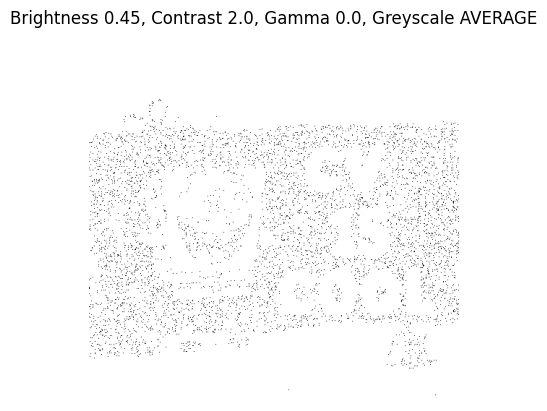

In [94]:
'''
TASK 1 RESULTS

This cell will provide the image configuration that I found best-revealed the secret phrase.
'''

# Load the provided image
photometricHiddenImage = cv2.imread("images/photometric_hidden_image.png")
photometricHiddenImage = cv2.cvtColor(photometricHiddenImage, cv2.COLOR_BGR2RGB)
photometricImageModifier = ImageModifier(photometricHiddenImage)

# Apply brightness, contrast, gamma, and greyscale modifications
modifiedImage = photometricImageModifier.changeImageBrightness(brightnessModifier=0.45)
modifiedImage = photometricImageModifier.changeImageContrast(image=modifiedImage, contrastModifier=2.0)
modifiedImage = photometricImageModifier.changeImageGamma(image=modifiedImage, gammaModifier=0.0)
modifiedImage = photometricImageModifier.changeImageGreyscale(image=modifiedImage, greyscaleType=GreyscaleType.AVERAGE)

# Display the results
finalImageDisplayer = ImageDisplay()
finalImageDisplayer.showImage(modifiedImage, "Brightness 0.45, Contrast 2.0, Gamma 0.0, Greyscale AVERAGE", doGreyMap=True)


## Task 2 Report: Geometric Puzzle Solver

The goal of Task 2 is to build a Geometric Puzzle Solver that performs transformations on tiles in a given image to unscramble the image. For full details, see [Assignment1.pdf](../Assignment1.pdf).

### Approach Strategy

My approach strategy for Task 2 was 

### Implementation

The implementation 

### Dependencies and Runtime Instructions

For Task 2, there are several dependencies required for the program:
1) 

### Task 2 Results